<a href="https://colab.research.google.com/github/AhsanRaza-dev/Avdvance_Deep_Learning/blob/master/hair_disease.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Enter your Kaggle Username: ahsanrazadev
Enter your Kaggle Key: ··········


100%|██████████| 564M/564M [00:08<00:00, 72.8MB/s]

Extracting files...



✅ Success! Dataset downloaded to: /root/.cache/kagglehub/datasets/sundarannamalai/hair-diseases/versions/1
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Found 9600 images belonging to 10 classes.
Found 1200 images belonging to 10 classes.
Found 1200 images belonging to 10 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step - accuracy: 0.5871 - loss: 1.2978
Epoch 1: val_loss improved from inf to 0.24287, saving model to best_model.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 164s 499ms/step - accuracy: 0.5876 - loss: 1.2960 - val_accuracy: 0.9467 - val_loss: 0.2429 - learning_rate: 0.0010
Epoch 2/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step - accuracy: 0.9412 - loss: 0.2449
Epoch 2: val_loss improved from 0.24287 to 0.15383, saving model to best_model.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 141s 471ms/step - accuracy: 0.9412 - loss: 0.2448 - val_accuracy: 0.9600 - val_loss: 0.1538 - learning_rate: 0.0010
Epoch 3/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step - accuracy: 0.9642 - loss: 0.1469
Epoch 3: val_loss improved from 0.15383 to 0.09060, saving model to best_model.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 143s 478ms/step - accuracy: 0.9642 - loss: 0.1469 - val_accuracy: 0.9742 - val_loss: 0.0906 - learning_rate: 0.0010
Epoch 4/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/s

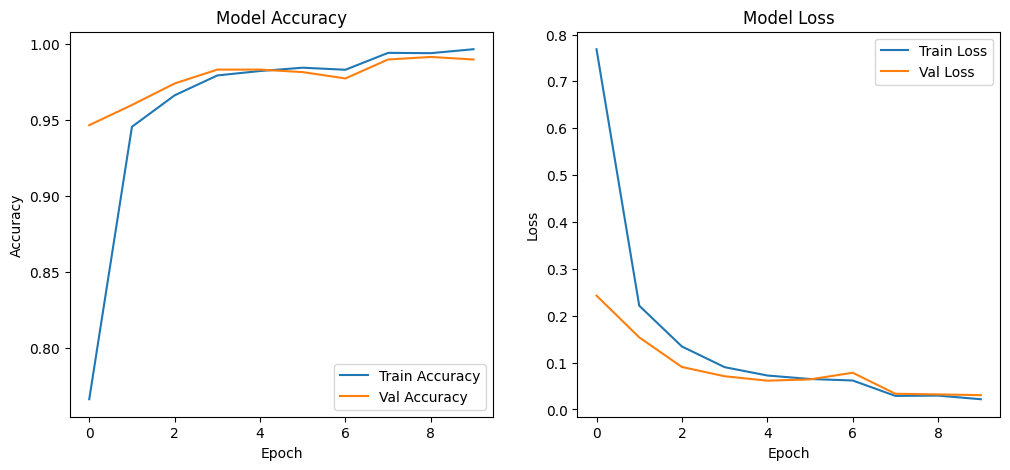

38/38 ━━━━━━━━━━━━━━━━━━━━ 7s 177ms/step


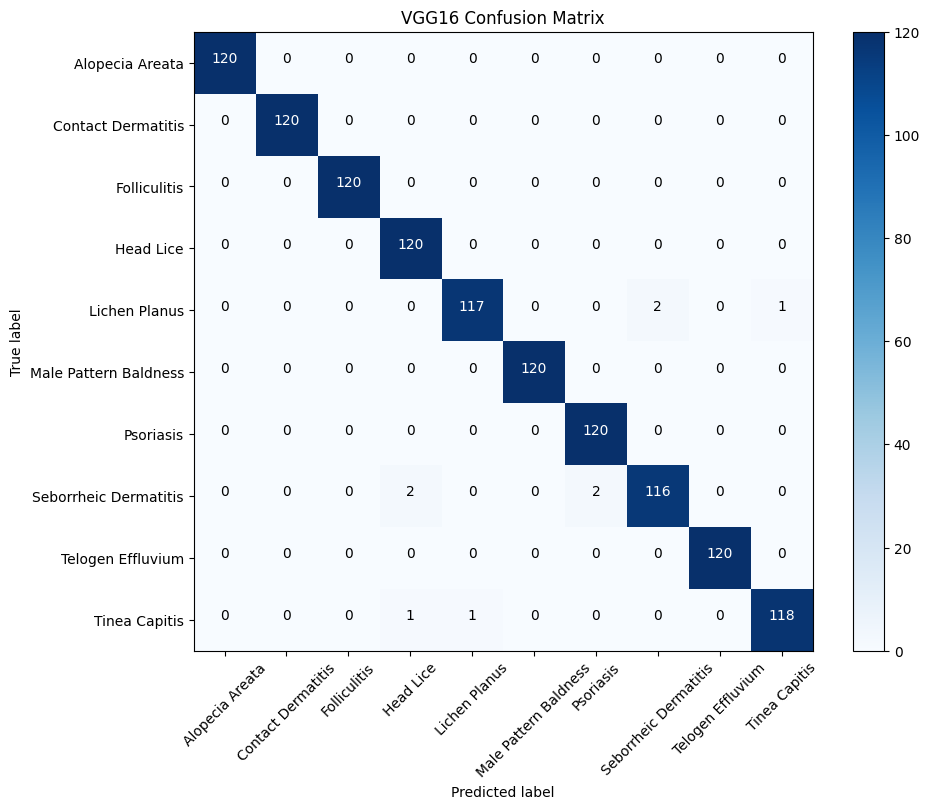

ValueError: Invalid filepath extension for saving. Please add either a `.keras` extension for the native Keras format (recommended) or a `.h5` extension. Use `model.export(filepath)` if you want to export a SavedModel for use with TFLite/TFServing/etc. Received: filepath=saved_model_hair.

In [1]:
import os
import kagglehub
import time
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import itertools
from getpass import getpass
from glob import glob
from sklearn.metrics import confusion_matrix
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

# --- 1. DOWNLOAD DATASET ---
os.environ["KAGGLE_USERNAME"] = input("Enter your Kaggle Username: ")
os.environ["KAGGLE_KEY"] = getpass("Enter your Kaggle Key: ")

try:
    dataset_path = kagglehub.dataset_download("sundarannamalai/hair-diseases")
    print("\n✅ Success! Dataset downloaded to:", dataset_path)
except Exception as e:
    print("\n❌ Error downloading dataset:", e)

# --- 2. DEFINE PATHS ---
base_path = os.path.join(dataset_path, "Hair Diseases - Final")
train_path = os.path.join(base_path, "train")
test_path = os.path.join(base_path, "test")
val_path = os.path.join(base_path, "val")

IMAGE_SIZE = [224, 224]

# --- 3. BUILD MODEL ---
vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

for layer in vgg.layers:
    layer.trainable = False

folders = glob(train_path + '/*')
num_classes = len(folders)

x = Flatten()(vgg.output)
prediction = Dense(num_classes, activation='softmax')(x)
model = Model(inputs=vgg.input, outputs=prediction)

model.compile(
  loss='categorical_crossentropy',
  optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
  metrics=['accuracy']
)

# --- 4. DATA AUGMENTATION ---
train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

training_set = train_datagen.flow_from_directory(
    train_path, target_size=(224, 224), batch_size=32, class_mode='categorical'
)

val_set = val_datagen.flow_from_directory(
    val_path, target_size=(224, 224), batch_size=32, class_mode='categorical', shuffle=False
)

test_set = test_datagen.flow_from_directory(
    test_path, target_size=(224, 224), batch_size=32, class_mode='categorical', shuffle=False
)

# --- 5. TRAINING ---
annealer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=3, verbose=1, min_lr=1e-5)
checkpoint = ModelCheckpoint('best_model.keras', verbose=1, save_best_only=True)

t_start = time.time()
history = model.fit(
    training_set,
    validation_data=val_set,
    epochs=10,
    callbacks=[annealer, checkpoint],
    steps_per_epoch=len(training_set),
    validation_steps=len(val_set)
)
print(f'\nTotal Training Time: {(time.time() - t_start)/60:.2f} mins')

# --- 6. PLOTTING PERFORMANCE ---
plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# --- 7. CONFUSION MATRIX ---
def plot_confusion_matrix(cm, target_names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

Y_pred = model.predict(test_set)
y_pred = np.argmax(Y_pred, axis=1)
cm = confusion_matrix(test_set.classes, y_pred)
target_names = list(test_set.class_indices.keys())

plot_confusion_matrix(cm, target_names, title='VGG16 Confusion Matrix')

# --- 8. SAVE & CONVERT TO TFLITE ---
# Save as SavedModel for high-quality conversion
model.save("saved_model_hair")

converter = tf.lite.TFLiteConverter.from_saved_model("saved_model_hair")
converter.optimizations = [tf.lite.Optimize.DEFAULT] # Optimization for mobile
tflite_model = converter.convert()

with open('hair_disease_model.tflite', 'wb') as f:
    f.write(tflite_model)

print("\n✅ hair_disease_model.tflite is ready for mobile deployment!")

Enter your Kaggle Username: ahsanrazadev
Enter your Kaggle Key: ··········
Using Colab cache for faster access to the 'hair-diseases' dataset.

✅ Success! Dataset downloaded to: /kaggle/input/hair-diseases
Found 9600 images belonging to 10 classes.
Found 1200 images belonging to 10 classes.
Found 1200 images belonging to 10 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 533ms/step - accuracy: 0.5745 - loss: 1.3296
Epoch 1: val_loss improved from inf to 0.31863, saving model to best_model.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 171s 562ms/step - accuracy: 0.5751 - loss: 1.3278 - val_accuracy: 0.9042 - val_loss: 0.3186 - learning_rate: 0.0010
Epoch 2/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step - accuracy: 0.9317 - loss: 0.2597
Epoch 2: val_loss improved from 0.31863 to 0.13319, saving model to best_model.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 145s 482ms/step - accuracy: 0.9318 - loss: 0.2596 - val_accuracy: 0.9683 - val_loss: 0.1332 - learning_rate: 0.0010
Epoch 3/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step - accuracy: 0.9727 - loss: 0.1336
Epoch 3: val_loss improved from 0.13319 to 0.11570, saving model to best_model.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 149s 497ms/step - accuracy: 0.9727 - loss: 0.1336 - val_accuracy: 0.9675 - val_loss: 0.1157 - learning_rate: 0.0010
Epoch 4/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/s

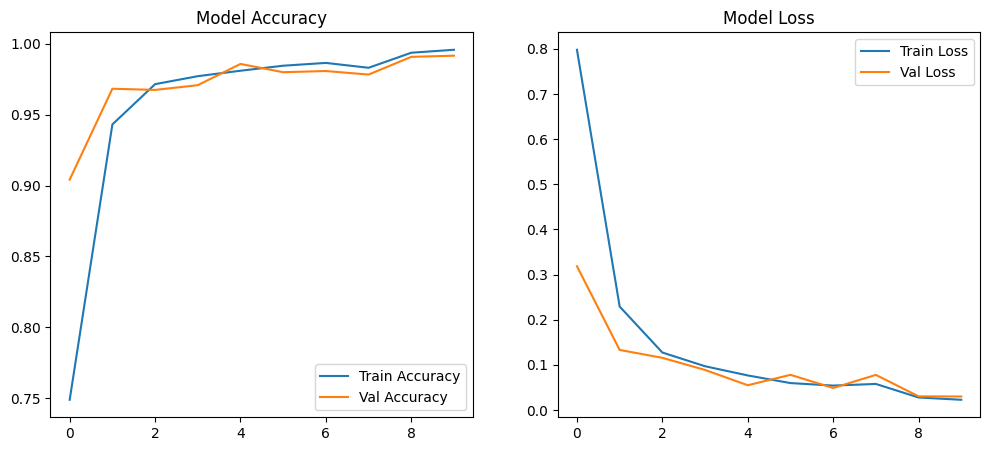

38/38 ━━━━━━━━━━━━━━━━━━━━ 8s 199ms/step

             DETAILED CLASSIFICATION REPORT
                       precision    recall  f1-score   support

      Alopecia Areata       1.00      1.00      1.00       120
   Contact Dermatitis       0.99      1.00      1.00       120
         Folliculitis       1.00      1.00      1.00       120
            Head Lice       1.00      1.00      1.00       120
        Lichen Planus       0.99      0.97      0.98       120
Male Pattern Baldness       1.00      1.00      1.00       120
            Psoriasis       1.00      1.00      1.00       120
Seborrheic Dermatitis       0.98      0.99      0.99       120
    Telogen Effluvium       1.00      1.00      1.00       120
        Tinea Capitis       0.99      0.99      0.99       120

             accuracy                           1.00      1200
            macro avg       1.00      1.00      1.00      1200
         weighted avg       1.00      1.00      1.00      1200



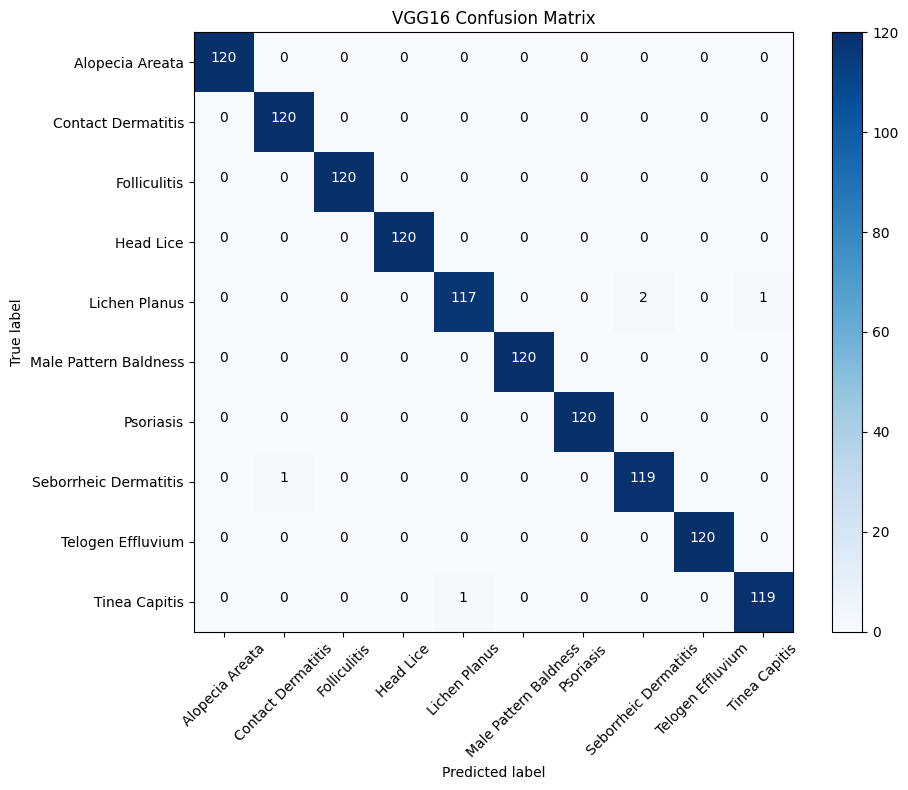

Saved artifact at 'exported_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_21')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  135264961207504: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135264961207312: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135264961208848: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135264961207888: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135264961209232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135264961209040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135264961209616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135264961209424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135264961210192: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135264961209808: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135264961210

In [2]:
import os
import kagglehub
import time
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import itertools
from getpass import getpass
from glob import glob
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

# --- 1. DOWNLOAD DATASET ---
os.environ["KAGGLE_USERNAME"] = input("Enter your Kaggle Username: ")
os.environ["KAGGLE_KEY"] = getpass("Enter your Kaggle Key: ")

try:
    dataset_path = kagglehub.dataset_download("sundarannamalai/hair-diseases")
    print("\n✅ Success! Dataset downloaded to:", dataset_path)
except Exception as e:
    print("\n❌ Error downloading dataset:", e)

# --- 2. DEFINE PATHS ---
base_path = os.path.join(dataset_path, "Hair Diseases - Final")
train_path = os.path.join(base_path, "train")
test_path = os.path.join(base_path, "test")
val_path = os.path.join(base_path, "val")

IMAGE_SIZE = [224, 224]

# --- 3. BUILD MODEL ---
vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

for layer in vgg.layers:
    layer.trainable = False

folders = glob(train_path + '/*')
num_classes = len(folders)

x = Flatten()(vgg.output)
prediction = Dense(num_classes, activation='softmax')(x)
model = Model(inputs=vgg.input, outputs=prediction)

model.compile(
  loss='categorical_crossentropy',
  optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
  metrics=['accuracy']
)

# --- 4. DATA AUGMENTATION ---
train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

training_set = train_datagen.flow_from_directory(
    train_path, target_size=(224, 224), batch_size=32, class_mode='categorical'
)

val_set = val_datagen.flow_from_directory(
    val_path, target_size=(224, 224), batch_size=32, class_mode='categorical', shuffle=False
)

test_set = test_datagen.flow_from_directory(
    test_path, target_size=(224, 224), batch_size=32, class_mode='categorical', shuffle=False
)

# --- 5. TRAINING ---
annealer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=3, verbose=1, min_lr=1e-5)
checkpoint = ModelCheckpoint('best_model.keras', verbose=1, save_best_only=True)

t_start = time.time()
history = model.fit(
    training_set,
    validation_data=val_set,
    epochs=10,
    callbacks=[annealer, checkpoint],
    steps_per_epoch=len(training_set),
    validation_steps=len(val_set)
)
print(f'\nTotal Training Time: {(time.time() - t_start)/60:.2f} mins')

# --- 6. PLOTTING PERFORMANCE ---
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.legend()
plt.show()

# --- 7. DETAILED TEST RESULTS (F1, Precision, Recall) ---
test_set.reset()
Y_pred = model.predict(test_set, steps=len(test_set), verbose=1)
y_pred = np.argmax(Y_pred, axis=1)
y_true = test_set.classes
class_labels = list(test_set.class_indices.keys())

print("\n" + "="*60)
print("             DETAILED CLASSIFICATION REPORT")
print("="*60)
print(classification_report(y_true, y_pred, target_names=class_labels))
print("="*60)

# --- 8. CONFUSION MATRIX ---
def plot_confusion_matrix(cm, target_names):
    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('VGG16 Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

cm = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm, class_labels)

# --- 9. EXPORT & CONVERT TO TFLITE ---
# Using model.export() to avoid the directory error in Keras 3
export_path = "exported_model"
model.export(export_path)

converter = tf.lite.TFLiteConverter.from_saved_model(export_path)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

with open('hair_disease_model.tflite', 'wb') as f:
    f.write(tflite_model)

print("\n✅ hair_disease_model.tflite is ready for mobile deployment!")